In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, r2_score

# 1) Build modeling table (NO LOG): route_id, target, lags

In [2]:
def build_model_table_no_log(
    df: pd.DataFrame,
    target_col: str = "fare_real",
    horizon: int = 1,                 # quarters ahead
    lags: tuple = (1, 4),
    lag_feature_cols: list | None = None,
):
    d = df.copy()

    # Required columns check
    required_cols = ["Year", "quarter", "citymarketid_1", "citymarketid_2", "nsmiles", target_col]
    missing = [c for c in required_cols if c not in d.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    # route_id (directionless)
    a = d["citymarketid_1"].astype(int)
    b = d["citymarketid_2"].astype(int)
    d["route_from"] = np.minimum(a, b)
    d["route_to"]   = np.maximum(a, b)
    d["route_id"]   = d["route_from"].astype(str) + "_" + d["route_to"].astype(str)

    # time index
    d["qtr_index"] = d["Year"].astype(int) * 4 + (d["quarter"].astype(int) - 1)
    d = d.sort_values(["route_id", "qtr_index"]).reset_index(drop=True)

    # Target in levels (NO LOG)
    d["y"] = pd.to_numeric(d[target_col], errors="coerce")
    d["y_target"] = d.groupby("route_id")["y"].shift(-horizon)

    # Lags of target
    for L in lags:
        d[f"y_lag{L}"] = d.groupby("route_id")["y"].shift(L)

    # Lag other features (forecast-safe)
    if lag_feature_cols is None:
        lag_feature_cols = []
    for c in lag_feature_cols:
        if c not in d.columns:
            continue
        for L in lags:
            d[f"{c}_lag{L}"] = d.groupby("route_id")[c].shift(L)

    # Feature list
    feature_cols = ["route_id", "quarter", "nsmiles"] + [f"y_lag{L}" for L in lags]
    for c in lag_feature_cols:
        for L in lags:
            colname = f"{c}_lag{L}"
            if colname in d.columns:
                feature_cols.append(colname)

    # Drop rows missing target or required lag history
    required_for_model = ["y_target"] + [f"y_lag{L}" for L in lags]
    model_df = d.dropna(subset=required_for_model).copy()

    # Make categorical
    model_df["route_id"] = model_df["route_id"].astype("category")

    return model_df, feature_cols

# 2) Time-series cross validation with LightGBM + R^2

In [3]:
def lgbm_timeseries_cv(
    model_df: pd.DataFrame,
    feature_cols: list,
    *,
    target_col: str = "y_target",
    time_col: str = "qtr_index",
    n_splits: int = 5,
    weight_col: str | None = "passengers",   # set None to disable
    params: dict | None = None,
    num_boost_round: int = 5000,
    early_stopping_rounds: int = 200,
    verbose_eval: int = 200,
    seed: int = 42,
):
    if params is None:
        params = {
            "objective": "regression",
            "metric": "mae",
            "learning_rate": 0.05,
            "num_leaves": 63,
            "min_data_in_leaf": 50,
            "feature_fraction": 0.8,
            "bagging_fraction": 0.8,
            "bagging_freq": 1,
            "seed": seed,
        }

    dfv = model_df.sort_values(time_col).reset_index(drop=True).copy()
    dfv["route_id"] = dfv["route_id"].astype("category")

    X = dfv[feature_cols]
    y = dfv[target_col].to_numpy()

    tscv = TimeSeriesSplit(n_splits=n_splits)

    fold_rows = []
    models = []

    all_y = []
    all_pred = []

    for fold, (tr_idx, va_idx) in enumerate(tscv.split(X), 1):
        X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
        y_tr, y_va = y[tr_idx], y[va_idx]

        # Optional weights
        w_tr = None
        w_va = None
        if weight_col is not None and weight_col in dfv.columns:
            w_tr = dfv.iloc[tr_idx][weight_col].fillna(0).clip(lower=0)
            w_va = dfv.iloc[va_idx][weight_col].fillna(0).clip(lower=0)

        dtrain = lgb.Dataset(
            X_tr, label=y_tr, weight=w_tr,
            categorical_feature=["route_id"], free_raw_data=False
        )
        dvalid = lgb.Dataset(
            X_va, label=y_va, weight=w_va,
            categorical_feature=["route_id"], reference=dtrain, free_raw_data=False
        )

        model = lgb.train(
            params,
            dtrain,
            num_boost_round=num_boost_round,
            valid_sets=[dtrain, dvalid],
            valid_names=["train", "valid"],
            callbacks=[
                lgb.early_stopping(early_stopping_rounds),
                lgb.log_evaluation(verbose_eval)
            ],
        )

        pred = model.predict(X_va, num_iteration=model.best_iteration)

        mae = float(mean_absolute_error(y_va, pred))
        rmse = float(np.sqrt(np.mean((y_va - pred) ** 2)))
        r2 = float(r2_score(y_va, pred))

        fold_rows.append({
            "fold": fold,
            "train_rows": int(len(tr_idx)),
            "valid_rows": int(len(va_idx)),
            "mae": mae,
            "rmse": rmse,
            "r2": r2,
            "best_iteration": int(model.best_iteration),
            "valid_time_min": int(dfv.loc[va_idx, time_col].min()),
            "valid_time_max": int(dfv.loc[va_idx, time_col].max()),
        })
        models.append(model)

        all_y.append(y_va)
        all_pred.append(pred)

    results_df = pd.DataFrame(fold_rows)

    all_y = np.concatenate(all_y)
    all_pred = np.concatenate(all_pred)

    summary = {
        "mae_mean": float(results_df["mae"].mean()),
        "mae_std": float(results_df["mae"].std(ddof=1)),
        "rmse_mean": float(results_df["rmse"].mean()),
        "rmse_std": float(results_df["rmse"].std(ddof=1)),
        "r2_mean": float(results_df["r2"].mean()),
        "r2_std": float(results_df["r2"].std(ddof=1)),
        "overall_cv_r2": float(r2_score(all_y, all_pred)),
    }

    return results_df, summary, models

# 3) RUN: build table -> CV -> print results

## Add cpi_adj

In [4]:
df = pd.read_excel("airline_ticket_dataset.xlsx")
cpi = pd.read_excel("CPI US.xlsx", sheet_name="Monthly")

def add_cpi(airline_ticket: pd.DataFrame, cpi:pd.DataFrame):
    airline_ticket["fare_per_miles"] = airline_ticket["fare"]/df["nsmiles"]
    
    cpi["Year"] = cpi["observation_date"].dt.year
    cpi["month"] = cpi["observation_date"].dt.month
    cpi["quarter"] = (cpi["month"] - 1) // 3 + 1

    cpi_q = (
        cpi.groupby(["Year", "quarter"], as_index=False)
           .agg(cpi_q=("CPIAUCSL", "mean"),
                months_in_q=("CPIAUCSL", "count"))
           .sort_values(["Year", "quarter"])
    )

    cpi_q["cpi_adj"] = cpi_q["cpi_q"]/284.905667 * 100
    cpi_q.drop([14, 15, 16], axis=0, inplace=True)
    
    airline_ticket = airline_ticket.merge(cpi_q[["Year", "quarter", "cpi_adj"]], on=["Year", "quarter"], how="right")
    nom_price = ["fare", "fare_lg", "fare_low"]

    for x in nom_price:
        airline_ticket[x + "_real"] = airline_ticket[x] * (100 / airline_ticket["cpi_adj"])
        
    return airline_ticket, cpi_q

df, cpi_q = add_cpi(df, cpi)
df.to_excel("cpi_added.xlsx", index=False)

import warnings
warnings.filterwarnings("ignore")

## Run

In [5]:
# Choose which columns you want lagged (forecast-safe)
lag_feature_cols = [
    "passengers",
    "large_ms", "lf_ms",
    "fare_lg_real", "fare_low_real",
    "TotalPerLFMkts_city1", "TotalPerPrem_city1",
    "TotalPerLFMkts_city2", "TotalPerPrem_city2",
]

model_df, feature_cols = build_model_table_no_log(
    df,
    target_col="fare_real",
    horizon=1,              # next quarter
    lags=(1, 4),
    lag_feature_cols=lag_feature_cols
)

cv_results, cv_summary, cv_models = lgbm_timeseries_cv(
    model_df=model_df,
    feature_cols=feature_cols,
    target_col="y_target",
    time_col="qtr_index",
    n_splits=5,
    weight_col="passengers",   # set None if you don't want weighting
    # params=...,              # optionally pass your own params dict
)

print("FEATURES USED:")
print(feature_cols)

print("\nCV RESULTS (per fold):")
print(cv_results)

print("\nCV SUMMARY:")
print(cv_summary)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4203
[LightGBM] [Info] Number of data points in the train set: 1386, number of used features: 23
[LightGBM] [Info] Start training from score 210.743327
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 200 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[59]	train's l1: 9.56837	valid's l1: 14.6928
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5844
[LightGBM] [Info] Number of data points in 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Number of data points in the train set: 5532, number of used features: 23
[LightGBM] [Info] Start training from score 209.466400
Training until validation scores don't improve for 200 rounds
[200]	train's l1: 4.77297	valid's l1: 14.9264
[400]	train's l1: 2.91439	valid's l1: 14.7882
[600]	train's l1: 1.97456	valid's l1: 14.7301
[800]	train's l1: 1.40402	valid's l1: 14.724
[1000]	train's l1: 1.03401	valid's l1: 14.7447
Early stopping, best iteration is:
[829]	train's l1: 1.34097	valid's l1: 14.7202
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6274
[LightGBM] [Info] Number of data points in the train 

# 4) Recursive Prediction, Hybrid Blend

In [6]:
import numpy as np
import pandas as pd
import lightgbm as lgb

def make_route_id_and_time(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()
    a = d["citymarketid_1"].astype(int)
    b = d["citymarketid_2"].astype(int)
    d["route_from"] = np.minimum(a, b)
    d["route_to"]   = np.maximum(a, b)
    d["route_id"]   = d["route_from"].astype(str) + "_" + d["route_to"].astype(str)
    d["qtr_index"]  = d["Year"].astype(int) * 4 + (d["quarter"].astype(int) - 1)
    return d

def build_recursive_safe_table(df: pd.DataFrame, target_col="fare_real", horizon=1, lags=(1,4)):
    d = make_route_id_and_time(df).sort_values(["route_id","qtr_index"]).reset_index(drop=True)
    d["y"] = pd.to_numeric(d[target_col], errors="coerce")
    d["y_target"] = d.groupby("route_id")["y"].shift(-horizon)
    for L in lags:
        d[f"y_lag{L}"] = d.groupby("route_id")["y"].shift(L)

    feature_cols = ["route_id", "quarter", "nsmiles"] + [f"y_lag{L}" for L in lags]
    model_df = d.dropna(subset=["y_target"] + [f"y_lag{L}" for L in lags]).copy()
    model_df["route_id"] = model_df["route_id"].astype("category")
    return model_df, feature_cols

def train_lgbm(model_df, feature_cols, weight_col="passengers", seed=42, num_boost_round=2000):
    X = model_df[feature_cols]
    y = model_df["y_target"].to_numpy()
    w = None
    if weight_col is not None and weight_col in model_df.columns:
        w = model_df[weight_col].fillna(0).clip(lower=0)

    dtrain = lgb.Dataset(
        X, label=y, weight=w,
        categorical_feature=["route_id"], free_raw_data=False
    )
    params = {
        "objective": "regression",
        "metric": "mae",
        "learning_rate": 0.05,
        "num_leaves": 63,
        "min_data_in_leaf": 50,
        "feature_fraction": 0.8,
        "bagging_fraction": 0.8,
        "bagging_freq": 1,
        "seed": seed,
    }
    return lgb.train(params, dtrain, num_boost_round=num_boost_round)

# Train horizon=1 recursive-safe model
h1_df, h1_features = build_recursive_safe_table(df, target_col="fare_real", horizon=1, lags=(1,4))
model_h1 = train_lgbm(h1_df, h1_features, weight_col="passengers")

# Train horizon=2 direct model (same feature set, just horizon=2)
h2_df, h2_features = build_recursive_safe_table(df, target_col="fare_real", horizon=2, lags=(1,4))
model_h2 = train_lgbm(h2_df, h2_features, weight_col="passengers")

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1744
[LightGBM] [Info] Number of data points in the train set: 8296, number of used features: 5
[LightGBM] [Info] Start training from score 210.441481
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1717


In [7]:
def advance_quarter(year: int, quarter: int, steps: int = 1):
    q_index = year * 4 + (quarter - 1) + steps
    new_year = q_index // 4
    new_quarter = (q_index % 4) + 1
    return int(new_year), int(new_quarter)

def get_last4_history(d_route: pd.DataFrame, target_col: str, last_qtr_index: int):
    # assumes d_route sorted by qtr_index
    hist = d_route[d_route["qtr_index"] <= last_qtr_index].dropna(subset=[target_col])
    if len(hist) < 4:
        raise ValueError(f"Need at least 4 historical quarters up to qtr_index={last_qtr_index}.")
    return hist[target_col].tail(4).to_list()

def hybrid_recursive_forecast(
    model_h1,
    model_h2,
    df: pd.DataFrame,
    *,
    cm1: int,
    cm2: int,
    last_known_year: int,
    last_known_quarter: int,
    years_ahead: int = 5,
    blend_w: float = 0.6,                 # weight on direct h=2 prediction (0.5–0.8 typical)
    damping_alpha: float | None = 0.85,   # smooth step-to-step jumps
    clip_global_quantiles: tuple[float, float] | None = (0.01, 0.99),
    target_col: str = "fare_real",
):
    d = make_route_id_and_time(df).sort_values(["route_id","qtr_index"]).reset_index(drop=True)
    route_id = f"{min(int(cm1), int(cm2))}_{max(int(cm1), int(cm2))}"

    # route slice
    d_route = d[d["route_id"] == route_id].copy()
    if d_route.empty:
        raise ValueError(f"Route {route_id} not found in data.")

    # locate last known
    last_qi = int(last_known_year) * 4 + (int(last_known_quarter) - 1)
    row_last = d_route[d_route["qtr_index"] == last_qi]
    if row_last.empty:
        raise ValueError(f"No row for route {route_id} at {last_known_year} Q{last_known_quarter}.")

    nsmiles = float(row_last["nsmiles"].iloc[0])

    # global clipping bounds
    lo, hi = None, None
    if clip_global_quantiles is not None:
        qlo, qhi = clip_global_quantiles
        hist_all = pd.to_numeric(d[target_col], errors="coerce").dropna()
        if len(hist_all) > 0:
            lo = float(hist_all.quantile(qlo))
            hi = float(hist_all.quantile(qhi))

    # rolling last4 values for y_lag4..y_lag1 window: [t-3,t-2,t-1,t]
    d_route[target_col] = pd.to_numeric(d_route[target_col], errors="coerce")
    last4 = get_last4_history(d_route, target_col, last_qi)
    prev = float(last4[-1])

    total_quarters = int(years_ahead) * 4
    out = []

    # We forecast in 2-quarter chunks: (t+1, t+2), then advance anchor by 2
    steps_done = 0
    anchor_year, anchor_quarter = last_known_year, last_known_quarter

    while steps_done < total_quarters:
        # ---- predict t+1 using h=1 model ----
        y_lag1 = float(last4[-1])
        y_lag4 = float(last4[0])
        y1_year, y1_qtr = advance_quarter(anchor_year, anchor_quarter, 1)

        X1 = pd.DataFrame([{
            "route_id": route_id,
            "quarter": int(y1_qtr),
            "nsmiles": nsmiles,
            "y_lag1": y_lag1,
            "y_lag4": y_lag4
        }])
        X1["route_id"] = X1["route_id"].astype("category")
        pred1 = float(model_h1.predict(X1, num_iteration=getattr(model_h1, "best_iteration", None))[0])

        if damping_alpha is not None:
            pred1 = damping_alpha * pred1 + (1 - damping_alpha) * prev
        if lo is not None and hi is not None:
            pred1 = float(np.clip(pred1, lo, hi))

        out.append({"route_id": route_id, "Year": y1_year, "quarter": y1_qtr, "pred_fare_real": pred1})
        steps_done += 1
        if steps_done >= total_quarters:
            break

        # ---- predict t+2 two ways ----
        y2_year, y2_qtr = advance_quarter(anchor_year, anchor_quarter, 2)

        # (A) direct t->t+2 using h=2 model (from anchor state)
        X2_direct = pd.DataFrame([{
            "route_id": route_id,
            "quarter": int(y2_qtr),
            "nsmiles": nsmiles,
            "y_lag1": float(last4[-1]),   # anchor t
            "y_lag4": float(last4[0])     # anchor t-3
        }])
        X2_direct["route_id"] = X2_direct["route_id"].astype("category")
        pred2_direct = float(model_h2.predict(X2_direct, num_iteration=getattr(model_h2, "best_iteration", None))[0])

        # (B) recursive t+1 -> t+2 using h=1 model, where lag1 becomes pred1
        X2_rec = pd.DataFrame([{
            "route_id": route_id,
            "quarter": int(y2_qtr),
            "nsmiles": nsmiles,
            "y_lag1": float(pred1),       # use predicted t+1
            "y_lag4": float(last4[1])     # this approximates the correct lag4 for t+1 anchor shift
        }])
        X2_rec["route_id"] = X2_rec["route_id"].astype("category")
        pred2_rec = float(model_h1.predict(X2_rec, num_iteration=getattr(model_h1, "best_iteration", None))[0])

        # Blend
        pred2 = float(blend_w * pred2_direct + (1 - blend_w) * pred2_rec)

        # Damping + clipping
        if damping_alpha is not None:
            pred2 = damping_alpha * pred2 + (1 - damping_alpha) * pred1
        if lo is not None and hi is not None:
            pred2 = float(np.clip(pred2, lo, hi))

        out.append({"route_id": route_id, "Year": y2_year, "quarter": y2_qtr, "pred_fare_real": pred2})
        steps_done += 1

        # ---- advance anchor by 2 quarters ----
        # Update last4 to reflect adding pred1, pred2
        last4 = last4[2:] + [pred1, pred2]   # drop two oldest, append two newest
        prev = pred2
        anchor_year, anchor_quarter = y2_year, y2_qtr

    return pd.DataFrame(out)

## Example Usage

In [8]:
forecast_hybrid = hybrid_recursive_forecast(
    model_h1=model_h1,
    model_h2=model_h2,
    df=df,
    cm1=32467, cm2=30852, # can be adjusted based on citymarketid_1 and citymarketid_2
    last_known_year=2025,
    last_known_quarter=2,
    years_ahead=10,
    blend_w=0.9,          # lean more on direct t+2 (usually reduces drift)
    damping_alpha=0.85,
    clip_global_quantiles=(0.01, 0.99)
)

forecast_hybrid

,route_id,Year,quarter,pred_fare_real
0,30852_32467,2025,3,179.259600
1,30852_32467,2025,4,172.766105
2,30852_32467,2026,1,175.889820
3,30852_32467,2026,2,179.659335
4,30852_32467,2026,3,179.045196
5,30852_32467,2026,4,176.331413
6,30852_32467,2027,1,177.329005
7,30852_32467,2027,2,179.673814
8,30852_32467,2027,3,179.047367
9,30852_32467,2027,4,176.481768


Used blend_w = 0.9 because it was the best blend_w after comparing several other values.

# Check Model Accuracy
Checked the model accuracy by using the data from Q1 2022 - Q4 2023 as the training set and Q1 2024 - Q2 2025 as the test set.

In [9]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

# -----------------------------
# Helpers
# -----------------------------
def prep_airline(df: pd.DataFrame, target_col="fare_real") -> pd.DataFrame:
    d = df.copy()
    a = d["citymarketid_1"].astype(int)
    b = d["citymarketid_2"].astype(int)
    d["route_from"] = np.minimum(a, b)
    d["route_to"]   = np.maximum(a, b)
    d["route_id"]   = d["route_from"].astype(str) + "_" + d["route_to"].astype(str)

    d["Year"] = d["Year"].astype(int)
    d["quarter"] = d["quarter"].astype(int)
    d["qtr_index"] = d["Year"] * 4 + (d["quarter"] - 1)

    d[target_col] = pd.to_numeric(d[target_col], errors="coerce")
    return d.sort_values(["route_id", "qtr_index"]).reset_index(drop=True)

def qtr_index(year: int, quarter: int) -> int:
    return int(year) * 4 + (int(quarter) - 1)

def year_quarter_from_qi(qi: int):
    y = qi // 4
    q = (qi % 4) + 1
    return int(y), int(q)

def quarter_pred(q: int, horizon: int) -> int:
    return int(((q - 1 + horizon) % 4) + 1)

# -----------------------------
# Route baseline from TRAIN window
# -----------------------------
def add_route_mean_train(d: pd.DataFrame, train_min_qi: int, train_max_qi: int, target_col="fare_real") -> pd.DataFrame:
    hist = d[(d["qtr_index"] >= train_min_qi) & (d["qtr_index"] <= train_max_qi)].copy()
    route_mean = (
        hist.dropna(subset=[target_col])
            .groupby("route_id")[target_col]
            .mean()
            .rename("route_mean_train")
            .reset_index()
    )
    return d.merge(route_mean, on="route_id", how="left")

# -----------------------------
# Supervised table (recursive-safe) for a given horizon
# Feature time t is restricted to train window
# -----------------------------
def build_supervised_train_window(
    d: pd.DataFrame,
    target_col="fare_real",
    horizon: int = 1,
    train_min_qi: int | None = None,
    train_max_qi: int | None = None,
):
    dfv = d.copy()
    dfv["y_curr"] = dfv[target_col]
    dfv["y_target"] = dfv.groupby("route_id")[target_col].shift(-horizon)

    # lags (do NOT require earlier-than-2022 data; NaNs are allowed)
    dfv["y_lag1"] = dfv.groupby("route_id")[target_col].shift(1)
    dfv["y_lag2"] = dfv.groupby("route_id")[target_col].shift(2)
    dfv["y_lag3"] = dfv.groupby("route_id")[target_col].shift(3)

    dfv["quarter_pred"] = dfv["quarter"].apply(lambda q: quarter_pred(q, horizon))

    # restrict feature time to train window
    if train_min_qi is not None:
        dfv = dfv[dfv["qtr_index"] >= train_min_qi]
    if train_max_qi is not None:
        dfv = dfv[dfv["qtr_index"] <= train_max_qi]

    dfv = dfv.dropna(subset=["y_curr", "y_target"]).copy()
    dfv["route_id"] = dfv["route_id"].astype("category")

    feature_cols = ["route_id", "quarter_pred", "nsmiles", "route_mean_train", "y_curr", "y_lag1", "y_lag2", "y_lag3"]
    feature_cols = [c for c in feature_cols if c in dfv.columns]
    return dfv, feature_cols

def train_lgbm(model_df, feature_cols, weight_col="passengers", seed=42, num_boost_round=2000):
    if model_df.empty:
        raise ValueError("Training table is empty. Check your train window and missing fares.")
    X = model_df[feature_cols]
    y = model_df["y_target"].to_numpy()

    w = None
    if weight_col is not None and weight_col in model_df.columns:
        w = model_df[weight_col].fillna(0).clip(lower=0)
        # cap mega-route dominance a bit
        cap = float(w.quantile(0.95)) if len(w) else None
        if cap and np.isfinite(cap) and cap > 0:
            w = w.clip(upper=cap)

    dtrain = lgb.Dataset(X, label=y, weight=w, categorical_feature=["route_id"], free_raw_data=False)

    params = {
        "objective": "regression",
        "metric": "mae",
        "learning_rate": 0.05,
        "num_leaves": 63,
        "min_data_in_leaf": 80,
        "feature_fraction": 0.85,
        "bagging_fraction": 0.85,
        "bagging_freq": 1,
        "seed": seed,
    }
    return lgb.train(params, dtrain, num_boost_round=num_boost_round)

# -----------------------------
# Hybrid forecast for one route from anchor (train_max) to test_max
# -----------------------------
def hybrid_forecast_one_route(
    model_h1, model_h2,
    route_hist: pd.DataFrame,
    start_qi: int, end_qi: int,
    feature_cols: list,
    blend_w: float = 0.7,
    damping_alpha: float = 0.85,
    target_col="fare_real",
    clip_quantiles=(0.01, 0.99)
):
    r = route_hist.sort_values("qtr_index").copy()
    r[target_col] = pd.to_numeric(r[target_col], errors="coerce")
    r = r.dropna(subset=[target_col])

    hist = r[r["qtr_index"] <= start_qi]
    if len(hist) < 4:
        return None

    # MUST have the anchor quarter row (e.g., 2023Q4)
    anchor_rows = hist[hist["qtr_index"] == start_qi]
    if anchor_rows.empty:
        return None

    anchor_row = anchor_rows.iloc[0]

    # seed state with last 4 actuals up to anchor
    last4 = hist[target_col].tail(4).to_list()  # t-3,t-2,t-1,t
    route_id = str(anchor_row["route_id"])
    nsmiles = float(anchor_row["nsmiles"])

    route_mean_train = np.nan
    if "route_mean_train" in hist.columns:
        route_mean_train = float(anchor_row["route_mean_train"])

    # route-level clipping
    lo = float(r[target_col].quantile(clip_quantiles[0]))
    hi = float(r[target_col].quantile(clip_quantiles[1]))

    y_t3, y_t2, y_t1, y_t = last4
    prev = float(y_t)

    def make_X(qi_target, y_curr, y_lag1, y_lag2, y_lag3):
        _, q = year_quarter_from_qi(qi_target)
        row = {
            "route_id": route_id,
            "quarter_pred": int(q),
            "nsmiles": float(nsmiles),
            "route_mean_train": route_mean_train,
            "y_curr": float(y_curr),
            "y_lag1": float(y_lag1),
            "y_lag2": float(y_lag2),
            "y_lag3": float(y_lag3),
        }
        X = pd.DataFrame([row])
        X["route_id"] = X["route_id"].astype("category")
        return X.reindex(columns=feature_cols)

    preds = []
    qi_anchor = start_qi

    while qi_anchor < end_qi:
        # t+1
        qi_1 = qi_anchor + 1
        X1 = make_X(qi_1, y_t, y_t1, y_t2, y_t3)
        p1 = float(model_h1.predict(X1)[0])
        p1 = damping_alpha * p1 + (1 - damping_alpha) * prev
        p1 = float(np.clip(p1, lo, hi))

        y1, q1 = year_quarter_from_qi(qi_1)
        preds.append({"route_id": route_id, "qtr_index": qi_1, "Year": y1, "quarter": q1, "pred_fare_real": p1})
        if qi_1 >= end_qi:
            break

        # t+2 (blend)
        qi_2 = qi_anchor + 2
        X2d = make_X(qi_2, y_t, y_t1, y_t2, y_t3)
        p2_direct = float(model_h2.predict(X2d)[0])

        X2r = make_X(qi_2, p1, y_t, y_t1, y_t2)
        p2_rec = float(model_h1.predict(X2r)[0])

        p2 = blend_w * p2_direct + (1 - blend_w) * p2_rec
        p2 = damping_alpha * p2 + (1 - damping_alpha) * p1
        p2 = float(np.clip(p2, lo, hi))

        y2, q2 = year_quarter_from_qi(qi_2)
        preds.append({"route_id": route_id, "qtr_index": qi_2, "Year": y2, "quarter": q2, "pred_fare_real": p2})

        # advance anchor by 2
        y_t3, y_t2, y_t1, y_t = y_t1, y_t, p1, p2
        prev = float(y_t)
        qi_anchor = qi_2

    return pd.DataFrame(preds)

# -----------------------------
# MAIN backtest: train 2022Q1–2023Q4, test remaining
# -----------------------------
def backtest_train_2022_to_2023Q4_test_rest(df_raw, blend_w=0.7, damping_alpha=0.85):
    d = prep_airline(df_raw, target_col="fare_real")

    train_min = qtr_index(2022, 1)
    train_max = qtr_index(2023, 4)
    test_min  = train_max + 1
    test_max  = int(d["qtr_index"].max())

    # add route baseline from training window
    d = add_route_mean_train(d, train_min, train_max, target_col="fare_real")

    # supervised training rows where feature time is inside the train window
    sup_h1, feats = build_supervised_train_window(d, "fare_real", horizon=1, train_min_qi=train_min, train_max_qi=train_max)
    sup_h2, _     = build_supervised_train_window(d, "fare_real", horizon=2, train_min_qi=train_min, train_max_qi=train_max)

    print("Train rows (h=1):", len(sup_h1), " | routes:", sup_h1["route_id"].nunique())
    print("Train rows (h=2):", len(sup_h2), " | routes:", sup_h2["route_id"].nunique())

    model_h1 = train_lgbm(sup_h1, feats, weight_col="passengers")
    model_h2 = train_lgbm(sup_h2, feats, weight_col="passengers")

    # routes to evaluate: must have 4 quarters up to anchor (train_max) + appear in test
    routes_seed = d[d["qtr_index"] <= train_max].groupby("route_id")["qtr_index"].nunique()
    good_routes = routes_seed[routes_seed >= 4].index
    routes_in_test = set(d[(d["qtr_index"] >= test_min) & (d["qtr_index"] <= test_max)]["route_id"].unique())
    good_routes = [r for r in good_routes if r in routes_in_test]
    
    # Require an actual (non-missing) anchor row at 2023Q4 for each route
    anchor_ok = (
        d[(d["qtr_index"] == train_max) & d["fare_real"].notna()]
        .groupby("route_id")
        .size()
    )

    good_routes = [r for r in good_routes if r in set(anchor_ok.index)]
    print("Routes with anchor 2023Q4:", len(good_routes))

    preds_list = []
    for rid in good_routes:
        rh = d[d["route_id"] == rid].copy()
        p = hybrid_forecast_one_route(model_h1, model_h2, rh, start_qi=train_max, end_qi=test_max,
                                      feature_cols=feats, blend_w=blend_w, damping_alpha=damping_alpha)
        if p is not None and not p.empty:
            preds_list.append(p)

    preds = pd.concat(preds_list, ignore_index=True) if preds_list else pd.DataFrame()

    actual = d[(d["qtr_index"] >= test_min) & (d["qtr_index"] <= test_max)][
        ["route_id","qtr_index","Year","quarter","fare_real","passengers"]
    ].copy()

    eval_df = actual.merge(preds, on=["route_id","qtr_index","Year","quarter"], how="inner")
    eval_df["abs_err"] = (eval_df["pred_fare_real"] - eval_df["fare_real"]).abs()
    eval_df["sq_err"]  = (eval_df["pred_fare_real"] - eval_df["fare_real"])**2
    eval_df["ape"] = eval_df["abs_err"] / eval_df["fare_real"].replace(0, np.nan)

    mae = float(mean_absolute_error(eval_df["fare_real"], eval_df["pred_fare_real"]))
    rmse = float(mean_squared_error(eval_df["fare_real"], eval_df["pred_fare_real"]))

    w = eval_df["passengers"].fillna(0).clip(lower=0).to_numpy()
    w_mae = float(np.sum(w * eval_df["abs_err"].to_numpy()) / np.sum(w)) if w.sum() > 0 else np.nan
    w_rmse = float(np.sqrt(np.sum(w * eval_df["sq_err"].to_numpy()) / np.sum(w))) if w.sum() > 0 else np.nan

    by_q = (
        eval_df.groupby("qtr_index")
               .agg(
                   Year=("Year","first"),
                   quarter=("quarter","first"),
                   n=("route_id","count"),
                   MAE=("abs_err","mean"),
                   RMSE=("sq_err", lambda x: float(np.sqrt(np.mean(x)))),
                   MdAPE=("ape","median"),
               )
               .reset_index()
               .sort_values("qtr_index")
    )

    summary = {
        "train_window": "2022Q1–2023Q4",
        "test_window": f"{year_quarter_from_qi(test_min)[0]}Q{year_quarter_from_qi(test_min)[1]}–{year_quarter_from_qi(test_max)[0]}Q{year_quarter_from_qi(test_max)[1]}",
        "routes_evaluated": int(eval_df["route_id"].nunique()),
        "rows_evaluated": int(len(eval_df)),
        "MAE": mae,
        "RMSE": rmse,
        "wMAE_passengers": w_mae,
        "wRMSE_passengers": w_rmse,
        "blend_w": float(blend_w),
        "damping_alpha": float(damping_alpha),
    }

    return summary, by_q, eval_df, (model_h1, model_h2), feats

In [10]:
summary, by_q, eval_df, (model_h1, model_h2), feats = backtest_train_2022_to_2023Q4_test_rest(
    df,
    blend_w=0.9,
    damping_alpha=0.85
)

print("SUMMARY:")
print(summary)
print("\nPER-QUARTER ERROR:")
print(by_q)

Train rows (h=1): 7938  | routes: 1173
Train rows (h=2): 7847  | routes: 1131
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2572
[LightGBM] [Info] Number of data points in the train set: 7938, number of used features: 8
[LightGBM] [Info] Start training from score 219.359943
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [11]:
summary

{'train_window': '2022Q1–2023Q4',
 'test_window': '2024Q1–2025Q2',
 'routes_evaluated': 962,
 'rows_evaluated': 5518,
 'MAE': 13.73807974828118,
 'RMSE': 379.6442805623011,
 'wMAE_passengers': 11.327594302778802,
 'wRMSE_passengers': 16.77841546130403,
 'blend_w': 0.9,
 'damping_alpha': 0.85}

In [12]:
by_q

,qtr_index,Year,quarter,n,MAE,RMSE,MdAPE
0,8096,2024,1,912,4.558137,6.943063,0.013396
1,8097,2024,2,932,5.880426,8.685217,0.017923
2,8098,2024,3,904,15.094618,19.648334,0.057786
3,8099,2024,4,940,18.519787,23.629134,0.070271
4,8100,2025,1,903,20.030164,25.352224,0.077292
5,8101,2025,2,927,18.368689,23.829407,0.072632


# 5) Predict CPI Growth
Since cpi_adj are not volatile, seen in the graph below, linear regression was used to forecast its growth in the future.

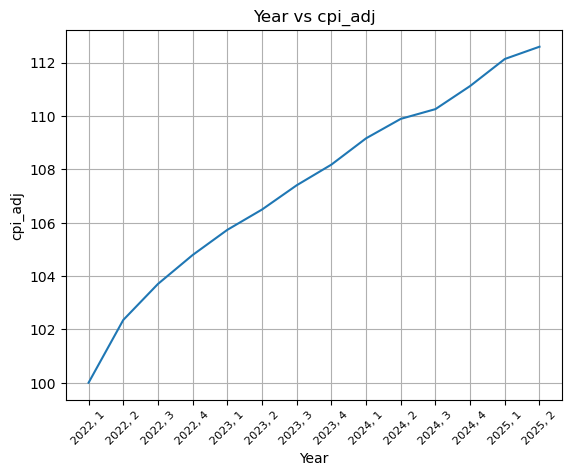

In [19]:
import matplotlib.pyplot as plt

cpi_q["year_quarter"] = cpi_q["Year"].astype(str) + ", " + cpi_q["quarter"].astype(str)

fig, ax = plt.subplots()
ax.plot(cpi_q["year_quarter"], cpi_q["cpi_adj"]) 

# Add labels and a title
ax.set(xlabel='Year', ylabel='cpi_adj',
       title='Year vs cpi_adj')
ax.grid()

plt.xticks(fontsize=8, rotation=45)
plt.show()

In [22]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

def fit_forecast_cpi_from_cpi_q(
    cpi_q: pd.DataFrame,
    forecast_to_year: int,
    forecast_to_quarter: int,
    *,
    use_quarter_dummies: bool = True,
    test_last_n_quarters: int = 8
):
    """
    Uses your existing cpi_q (Year, quarter, cpi_q).
    Fits linear regression: cpi_q ~ time (+ quarter dummies optional).
    Does a time-based backtest on last N quarters, then forecasts forward.
    """
    d = cpi_q.copy().sort_values(["Year", "quarter"]).reset_index(drop=True)

    # Create qtr_index
    d["qtr_index"] = d["Year"].astype(int) * 4 + (d["quarter"].astype(int) - 1)

    # Features
    X = pd.DataFrame({"t": d["qtr_index"].astype(int)})
    if use_quarter_dummies:
        qdum = pd.get_dummies(d["quarter"].astype(int), prefix="Q", drop_first=True)
        X = pd.concat([X, qdum], axis=1)

    y = d["cpi_q"].astype(float).to_numpy()

    # time split (last N quarters as test)
    if len(d) <= test_last_n_quarters + 5:
        raise ValueError("Not enough quarterly CPI observations for this backtest. Reduce test_last_n_quarters.")

    split = len(d) - test_last_n_quarters
    X_train, y_train = X.iloc[:split], y[:split]
    X_test, y_test = X.iloc[split:], y[split:]

    model = LinearRegression()
    model.fit(X_train, y_train)

    pred_test = model.predict(X_test)
    metrics = {
        "use_quarter_dummies": use_quarter_dummies,
        "test_last_n_quarters": test_last_n_quarters,
        "MAE": float(mean_absolute_error(y_test, pred_test)),
        "R2": float(r2_score(y_test, pred_test)),
        "train_end": f"{int(d.iloc[split-1]['Year'])}Q{int(d.iloc[split-1]['quarter'])}",
        "test_start": f"{int(d.iloc[split]['Year'])}Q{int(d.iloc[split]['quarter'])}",
        "test_end": f"{int(d.iloc[-1]['Year'])}Q{int(d.iloc[-1]['quarter'])}",
    }

    # Forecast future quarters
    last_qi = int(d["qtr_index"].max())
    end_qi = int(forecast_to_year) * 4 + (int(forecast_to_quarter) - 1)
    if end_qi <= last_qi:
        raise ValueError("forecast_to_year/quarter must be after the last quarter in cpi_q.")

    future_qi = np.arange(last_qi + 1, end_qi + 1)
    future_year = future_qi // 4
    future_quarter = (future_qi % 4) + 1

    X_future = pd.DataFrame({"t": future_qi})
    if use_quarter_dummies:
        qdum_f = pd.get_dummies(future_quarter, prefix="Q", drop_first=True)

        # ensure columns match training
        X_future = pd.concat([X_future, qdum_f], axis=1)
        X_future = X_future.reindex(columns=X.columns, fill_value=0)

    pred_future = model.predict(X_future)

    forecast_df = pd.DataFrame({
        "Year": future_year.astype(int),
        "quarter": future_quarter.astype(int),
        "qtr_index": future_qi.astype(int),
        "cpi_q_pred": pred_future
    })

    return model, metrics, forecast_df

In [23]:
m_trend, met_trend, fc_trend = fit_forecast_cpi_from_cpi_q(
    cpi_q, forecast_to_year=2030, forecast_to_quarter=4, use_quarter_dummies=False
)
m_seas, met_seas, fc_seas = fit_forecast_cpi_from_cpi_q(
    cpi_q, forecast_to_year=2030, forecast_to_quarter=4, use_quarter_dummies=True
)

print("Trend-only:", met_trend)
print("Trend+quarter dummies:", met_seas)

best_fc = fc_seas if met_seas["MAE"] <= met_trend["MAE"] else fc_trend
best_fc.head()

Trend-only: {'use_quarter_dummies': False, 'test_last_n_quarters': 8, 'MAE': 7.085677777777761, 'R2': -1.5858123973933047, 'train_end': '2023Q2', 'test_start': '2023Q3', 'test_end': '2025Q2'}
Trend+quarter dummies: {'use_quarter_dummies': True, 'test_last_n_quarters': 8, 'MAE': 7.0887499999991235, 'R2': -1.5326992835302744, 'train_end': '2023Q2', 'test_start': '2023Q3', 'test_end': '2025Q2'}


,Year,quarter,qtr_index,cpi_q_pred
0,2025,3,8102,336.737673
1,2025,4,8103,340.292635
2,2026,1,8104,343.847597
3,2026,2,8105,347.402559
4,2026,3,8106,350.957521


In [24]:
BASE_CPI = 284.905667

cpi_future = best_fc.copy()
cpi_future["cpi_adj_pred"] = cpi_future["cpi_q_pred"] / BASE_CPI * 100

cpi_future.head()

,Year,quarter,qtr_index,cpi_q_pred,cpi_adj_pred
0,2025,3,8102,336.737673,118.192690
1,2025,4,8103,340.292635,119.440458
2,2026,1,8104,343.847597,120.688227
3,2026,2,8105,347.402559,121.935995
4,2026,3,8106,350.957521,123.183763


In [25]:
cpi_future.tail()

,Year,quarter,qtr_index,cpi_q_pred,cpi_adj_pred
17,2029,4,8119,397.172025,139.404747
18,2030,1,8120,400.726987,140.652515
19,2030,2,8121,404.281949,141.900284
20,2030,3,8122,407.836911,143.148052
21,2030,4,8123,411.391873,144.395820
